# Week 5
Last week's version included a simple battery class, market class, and a basic Q-learning implementation. 
In this week's version I will: 
- Extend the battery class with an `idle`-action and battery **efficiency**.
- Extend the market class with **more prices** and **real price data**.
- Use **linear programming** the see if last week's solution of the agent on the sine wave pricing was actually correct.
- Plot some curves to **visualize how the agent learns**.

# 1. Idle action + learning curve

## 1.1 Market class

In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Market:
    def __init__(self, duration_hours=24, timestep_minutes=15, pattern="square", high_price=10, low_price=-10, price_levels_num=10):
        if not (low_price < high_price):
            raise ValueError("Lowest price must be lower than highest price.")
        self.duration_hours = duration_hours
        self.timestep_minutes = timestep_minutes
        self.pattern = pattern
        self.high_price = high_price
        self.low_price = low_price
        self.num_steps = int(duration_hours * 60 / timestep_minutes)
        self.price_levels_num = price_levels_num
        self.prices, self.prices_discrete = self._generate_prices()

    def reset(self):
        self.prices, self.prices_discrete = self._generate_prices()
    
    def _generate_prices(self):
        if self.pattern == "square":
            prices = self._generate_square_wave()
        elif self.pattern == "sinus":
            prices = self._generate_sinus_wave()
        else:
            raise ValueError(f"Unknown pattern type: {self.pattern}")
    
        # Discretize prices
        levels = np.linspace(self.low_price, self.high_price, self.price_levels_num)
        prices_discrete = np.round(
            np.array([levels[np.argmin(np.abs(levels - p))] for p in prices]), 2
        )
    
        return prices, prices_discrete
    
    def _generate_square_wave(self):
        prices = []
        toggle = random.choice([self.high_price, self.low_price])
        i = 0
        while i < self.num_steps:
            block_length = random.randint(2, 16) # how many timesteps this block lasts
            for _ in range(block_length):
                if i >= self.num_steps:
                    break
                prices.append(toggle)
                i += 1
            toggle = self.high_price if toggle == self.low_price else self.low_price
        return np.array(prices)
    
    def _generate_sinus_wave(self):
        x = np.linspace(0, 2 * np.pi * 4, self.num_steps, endpoint=False)
        mid = (self.high_price + self.low_price) / 2
        amplitude = (self.high_price - self.low_price) / 2
        prices = mid + amplitude * np.sin(x)
        return prices
    
    def plot(self):
        x = range(len(self.prices))
        plt.step(x, self.prices, label="Real Prices")
        plt.step(x, self.prices_discrete, label="Discrete Prices", alpha=0.6)
        plt.title("Imbalance Market Prices")
        plt.xlabel(f"Timestep ({self.timestep_minutes} min each)")
        plt.ylabel("Price")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        plt.show()

## 1.2 Battery class (extended with an idle action)

In [39]:
class Battery:    
    def __init__(self, soc=15, capacity=30, power=5):
        if not (0 <= soc <= capacity):
            raise ValueError("SOC must be between 0 and capacity.")
        self.soc = soc # kWh
        self.capacity = capacity # kWh
        self.power = power # kW
        self.history = [] # list of (soc, time, action)

    def get_soc(self):
        return self.soc
    
    def charge(self, duration=15):
        """Charge the battery (duration in minutes)."""
        self.history.append((self.soc, duration, 2))
        energy_added = self.power * (duration / 60)
        soc_before = self.soc
        self.soc = min(self.capacity, self.soc + energy_added)
        return self.soc - soc_before
    
    def idle(self, duration=15):
        """Idle the battery (duration in minutes)."""
        self.history.append((self.soc, duration, 1))
        return 0.0
    
    def discharge(self, duration=15):
        """Discharge the battery (duration in minutes)."""
        self.history.append((self.soc, duration, 0))
        energy_removed = self.power * (duration / 60)
        soc_before = self.soc
        self.soc = max(0, self.soc - energy_removed)
        return self.soc - soc_before
    
    def get_history(self):
        return self.history

    def reset(self, soc=15):
        if not (0 <= soc <= self.capacity):
            raise ValueError("SOC must be between 0 and capacity.")
        self.history = []
        self.soc = soc

    def __repr__(self):
        return f"Battery(SOC={self.soc:.2f}/{self.capacity} kWh)"


## 1.3 Q-learning setup

### Environment parameters + Q-learning hyperparameters

In [40]:
import dataclasses
from dataclasses import dataclass

@dataclass
class Config:
    timestep_min = 15
    duration_hours=24
    initial_soc = 15
    capacity = 30
    power = 5
    price_levels_num = 10
    high_price = 10
    low_price = -10
    pattern = "sinus"
    
    # Q-learning
    alpha = 0.05
    gamma = 0.95
    epsilon = 0.2
    n_episodes = 1000

cfg = Config()

### Battery and market

Battery(SOC=15.00/30 kWh)


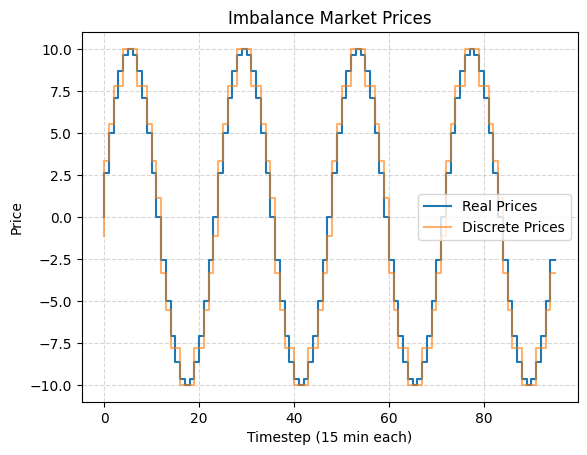

In [41]:
battery = Battery(soc=cfg.initial_soc, capacity=cfg.capacity, power=cfg.power)
market = Market(
    pattern=cfg.pattern, 
    duration_hours=cfg.duration_hours, 
    timestep_minutes=cfg.timestep_min, 
    high_price=cfg.high_price, 
    low_price=cfg.low_price,
    price_levels_num=cfg.price_levels_num,
)
print(battery)
market.plot()

### Q-learning setup

In [42]:
from enum import IntEnum

class Action(IntEnum):
    IDLE = 0
    CHARGE = 1
    DISCHARGE = 2
    
n_states = (cfg.capacity + 1) + (cfg.capacity + 1) * cfg.price_levels_num
Q = np.zeros((n_states, len(Action)))

possible_prices = np.unique(market.prices_discrete)
price_to_index = { price:index for index,price in enumerate(possible_prices) }

def state_to_index(soc, price):
    soc_bin = int(round(soc))
    price_index = price_to_index[price]
    return soc_bin + (cfg.capacity + 1) * price_index

In [43]:
def step(time_index, action):
    price = market.prices_discrete[time_index]
    reward = 0.0
    if action == Action.DISCHARGE:
        delivered = -battery.discharge(duration=cfg.timestep_min)
        reward = price * delivered
    elif action == Action.IDLE:
        battery.idle(duration=cfg.timestep_min)
        reward = 0.0
    else:
        stored = battery.charge(duration=cfg.timestep_min)
        reward = -price * stored
    next_index = time_index + 1
    return reward, next_index

### Q-Learning

In [44]:
episode_rewards = []

for _ in range(cfg.n_episodes):
    battery.reset(soc=cfg.initial_soc)
    market.reset()
    t = 0
    s = state_to_index(battery.get_soc(), market.prices_discrete[t])
    total_reward = 0
    while t < market.num_steps:
        if random.random() < cfg.epsilon:
            a = random.choice(list(Action))
        else:
            a = Action(int(np.argmax(Q[s])))

        r, t_next = step(t, a)
        total_reward += r

        if t_next < market.num_steps:
            s_next = state_to_index(battery.get_soc(), market.prices_discrete[t_next])
            td_target = r + cfg.gamma * np.max(Q[s_next])
        else:
            s_next = None
            td_target = r
        
        Q[s, a] += cfg.alpha * (td_target - Q[s, a])
        s = s_next if s_next is not None else s
        t = t_next
    episode_rewards.append(total_reward)

In [45]:
print("Q-table shape:", Q.shape)

Q-table shape: (341, 3)


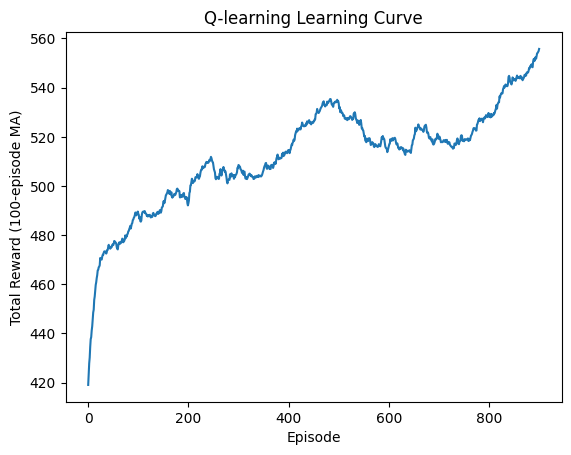

In [46]:
window = 100

plt.plot(np.convolve(episode_rewards, np.ones(window)/window, mode='valid'))
plt.xlabel("Episode")
plt.ylabel(f"Total Reward ({window}-episode MA)")
plt.title("Q-learning Learning Curve")
plt.show()

## 1.4 Test the agent

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actions(battery, market, timestep, initial_soc):
    history = battery.get_history()
    soc_history = []
    time_steps = []
    actions = []
    dt = timestep
    current_time = 0
    current_soc = initial_soc
    for entry in history:
        soc_before, duration_min, action = entry
        steps = int(duration_min / dt) if duration_min >= dt else 1
        for s in range(steps):
            time_steps.append(current_time)
            soc_history.append(current_soc)
            actions.append(action)
            if action == 2:
                # charge
                added = battery.power * (dt / 60)
                current_soc = min(battery.capacity, current_soc + added)
            elif action == 0:
                # discharge
                removed = battery.power * (dt / 60)
                current_soc = max(0, current_soc - removed)
            # if action == 1 (idle): do nothing
            current_time += 1

    # Convert market prices to align with time_steps
    price_ts = market.prices[:len(time_steps)] if len(market.prices) >= len(time_steps) else np.pad(
        market.prices,
        (0, len(time_steps) - len(market.prices)),
        constant_values=(market.prices[-1] if len(market.prices) > 0 else 0)
    )

    # Plot
    fig, ax1 = plt.subplots(figsize=(14,4))
    ax2 = ax1.twinx()

    # Price as stepped line
    ax1.step(range(len(price_ts)), price_ts, where='post', color='tab:blue', linewidth=2, label='Market price [€/kWh]')
    ax1.set_ylabel('Price [€/kWh]', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # SOC as line
    ax2.plot(range(len(soc_history)), soc_history, color='tab:orange', label='Battery SOC (kWh)')
    ax2.set_ylabel('SOC (kWh)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Mark actions
    for idx, act in enumerate(actions):
        if act is None:
            continue
        if act == 2:
            ax2.scatter(idx, soc_history[idx], color='green', marker='^', s=40, label='Charge' if idx==0 else "")
        elif act == 0:
            ax2.scatter(idx, soc_history[idx], color='red', marker='v', s=40, label='Discharge' if idx==0 else "")
        elif act == 1:
            ax2.scatter(idx, soc_history[idx], color='gray', marker='o', s=30, label='Idle' if idx==0 else "")

    ax1.set_title('Market prices and Battery actions over time')
    ax1.set_xlabel('Timestep')
    ax1.grid(True, linestyle='--', alpha=0.4)
    fig.tight_layout()
    plt.show()


One-day simulation profit: €775.10


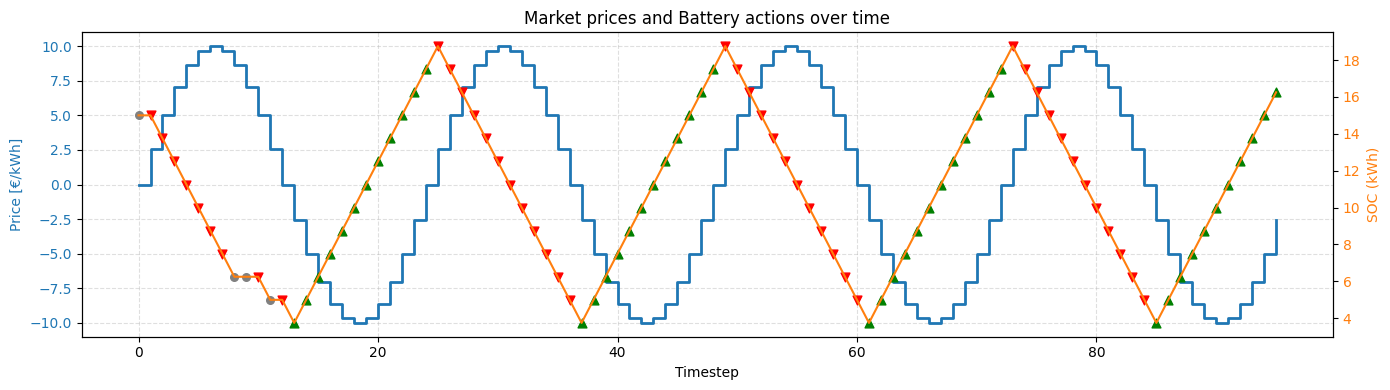

In [48]:
battery.reset(soc=cfg.initial_soc)
market.reset()
total_profit = 0.0
for t in range(market.num_steps):
    s = state_to_index(battery.get_soc(), market.prices_discrete[t])
    a = Action(int(np.argmax(Q[s])))
    r, _ = step(t, a)
    total_profit += r
print(f"One-day simulation profit: €{total_profit:.2f}")

# Plot results
plot_actions(battery=battery, market=market, timestep=cfg.timestep_min, initial_soc=cfg.initial_soc)

# 2. Optimization